In [1]:
'''
Statistical and Machine Learning Methods in Particle and Astrophysics
TUM - summer term 2019
M. Agostini <matteo.agostini@tum.de> and Hans Niederhausen@tum.de <hans.niederhausen@tum.de>

Ex 4, "A realistic maximum likelihood analysis: 
        The discovery of a diffuse flux of high-energy astrophysical neutrinos by IceCube"

    learning goals: perform a maximum likelihood analysis with binned observations
    1) build a (complex) statistical model from events generated with Monte Carlo techniques
    2) generate data (counts) from the model prediction
    3) extract estimated (MLE) model parameters from the generated data
    4) perform hypothesis test (MLR): H0: bkg only - against - H1: bkg + signal 
        4a) calculate observed test-statistic value
        4b) repeat steps 2-3-4 and build probability distribution of the test statistic for the bkg only case
        4c) calculate p-value (evidence against bkg only case)
       
the example is motivated by the following papers: 
Phys. Rev. Lett. 113, 101101 (2014)
Phys. Rev. D 91, 022001 (2015)
'''

'\nStatistical and Machine Learning Methods in Particle and Astrophysics\nTUM - summer term 2019\nM. Agostini <matteo.agostini@tum.de> and Hans Niederhausen@tum.de <hans.niederhausen@tum.de>\n\nEx 4, "A realistic maximum likelihood analysis: \n        The discovery of a diffuse flux of high-energy astrophysical neutrinos by IceCube"\n\n    learning goals: perform a maximum likelihood analysis with binned observations\n    1) build a (complex) statistical model from events generated with Monte Carlo techniques\n    2) generate data (counts) from the model prediction\n    3) extract estimated (MLE) model parameters from the generated data\n    4) perform hypothesis test (MLR): H0: bkg only - against - H1: bkg + signal \n        4a) calculate observed test-statistic value\n        4b) repeat steps 2-3-4 and build probability distribution of the test statistic for the bkg only case\n        4c) calculate p-value (evidence against bkg only case)\n       \nthe example is motivated by the fol

In [1]:
from analyze_data import diffuse_analysis
import numpy as np
import matplotlib.pyplot as plt

# need to import mc event generator
from generate_mcevents import generate_pseudoMC

# number of mc events to be generated (or loaded)
nevents = 1.e4

# the line below will generate the MC events and write them to disk
# this needs to be done only once.
# if the MC events have already been generated in a previous step
# simply comment out the line below.
#outfiles = generate_pseudoMC(nevents)

# insted, if the MC events already exist on disk
# simply uncomment the line below
# and no events will be newly generated but the location of the MC events on disk will be returned
outfiles = generate_pseudoMC(nevents, precomputed=True)

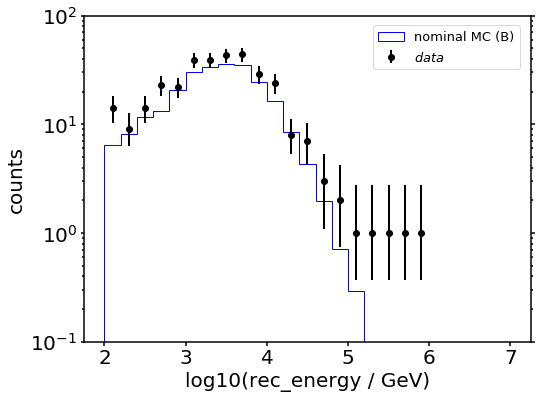

In [2]:
# read MC events from disk
# prepare functions to calculate the model prediction for the poisson means in each analysis bin 
# (expected counts)
ana = diffuse_analysis(outfiles, seed=0)

# for now assume 3 years of detector operation
ana.set_ltime(3)

# set 5 bins per decade from 100 GeV to 10 PeV in reconstructed energy (our observable)
edges = np.linspace(2.0, 7.0, 26) 
centers = 0.5*(edges[1:]+edges[:-1])

# in what follows we distinguish between nominal parameters ("nominal MC") and the parameters
# realized in our hypothetical universe ("true MC").
# nominal MC corresponds to the parameter values that are assumed plausible before our experiment is carried out.
# (i.e. either from previous measurements or theory considerations)

# define nominal MC values
conv_norm = 1.0
astro_norm = 1.0
astro_gamma = 2.0
pars_mc = [conv_norm, astro_norm, astro_gamma]

# generate the model prediction in each analysis bin from MC for "nominal values"
mus_sum = ana.get_expectations(edges, pars_mc) # S+B
mus_conv = ana.get_expectations_conv(edges, conv_norm) # B
mus_astro = ana.get_expectations_astro(edges, [astro_norm, astro_gamma]) # S

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# we will visualize the nominal bkg expectation first
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_conv, histtype='step', color='blue', linewidth=1, zorder=10, label='nominal MC (B)')

# in a real life experiment the nominal assumption never fits the data exactly.
# we therefore generate pseudo-data from a slightly different set of parameter values ("true MC")
# these parameter values are the "true" values realized by nature in our hypothetical universe

conv_norm = 1.1
astro_norm = 1.0
astro_gamma = 2.3
pars_nature = [conv_norm, astro_norm, astro_gamma]

# generate the model prediction in each analysis bin from MC for "true values"
mus_nature = ana.get_expectations(edges, pars_nature)

# generate poisson random variables from model prediction
pseudo_data = ana.generate_pseudo_data(mus_nature)

# visualize "observed" data
pseudo_data_err_low, pseudo_data_err_up = ana.get_poisson_confidence_intervals(pseudo_data)
ax.errorbar(centers, pseudo_data,yerr=[pseudo_data_err_low, pseudo_data_err_up], label='$data$', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

ax.set_yscale('log')
ax.set_ylim([1.e-1, 100])

ax.set_xlabel('log10(rec_energy / GeV)', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

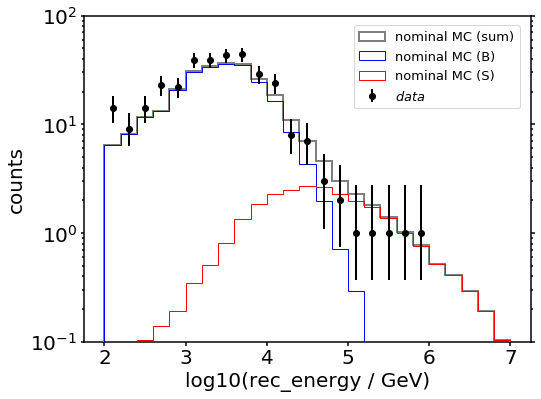

In [12]:
# same plot as before
# but we also add the nominal signal prediction (red)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_sum, histtype='step', color='gray', linewidth=2, zorder=10, label='nominal MC (sum)')
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_conv, histtype='step', color='blue', linewidth=1, zorder=10, label='nominal MC (B)')
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_astro, histtype='step', color='red', linewidth=1, zorder=10, label='nominal MC (S)')

ax.errorbar(centers, pseudo_data,yerr=[pseudo_data_err_low, pseudo_data_err_up], label='$data$', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

ax.set_yscale('log')
ax.set_ylim([1.e-1, 100])

ax.set_xlabel('log10(rec_energy / GeV)', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# note: the MC and the data do not match exactly because the correspond to different sets
# of parameter values.
# However the nominal parameter values will provide a reasonable seed for the numerical likelihood optimization
# we will do later on.

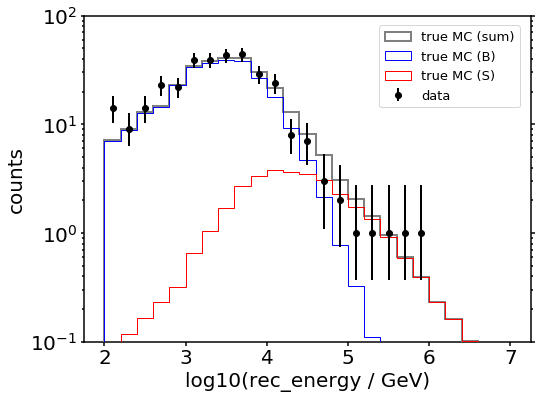

In [13]:
# now replace the nominal MC expectations
# with the true MC expectations

# this compares the realized data observations to the true model that generated the data

# generate the model prediction in each analysis bin from MC for "true values"
mus_nature = ana.get_expectations(edges, pars_nature)
mus_conv_nature = ana.get_expectations_conv(edges, pars_nature[0])
mus_astro_nature = ana.get_expectations_astro(edges, pars_nature[1:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_nature, histtype='step', color='gray', linewidth=2, zorder=10, label='true MC (sum)') 
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_conv_nature, histtype='step', color='blue', linewidth=1, zorder=10, label='true MC (B)') 
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_astro_nature, histtype='step', color='red', linewidth=1, zorder=10, label='true MC (S)')

ax.errorbar(centers, pseudo_data,yerr=[pseudo_data_err_low, pseudo_data_err_up], label='data', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

ax.set_yscale('log')
ax.set_ylim([1.e-1, 100])

ax.set_xlabel('log10(rec_energy / GeV)', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# obviously the data is described better by the true set of parameter values
# note the large statistical fluctuations in the signal region (high energy)
# where each bin contains only a few events

[1.292315434031253, 0.0, 0.0]


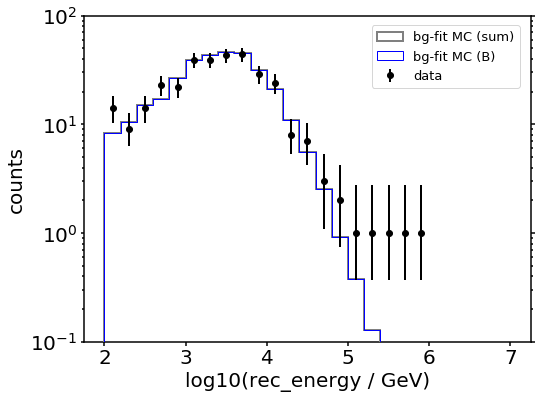

In [14]:
# Let us start with the background only fit
# the background only fit has only one free parameter: the normalization of the background component
# (related to the intensity of the flux of conventional atmospheric neutrinos)

conv_norm_seed = pars_mc[0]
restricted_pars_seed = [conv_norm_seed]

# since we are interested in the background-only scenario
# we need to fix the signal expectation to 0 
astro_norm_H0 = 0.0
astro_index_H0 = 12.0 # undefined for norm=0.0, could be any value.

pars_H0 = [astro_norm_H0, astro_norm_H0] 

# get the estimated background normalization from the background fit
pars_fit, neg_logllh_fit = ana.get_restricted_fit(bins, pseudo_data, restricted_pars_seed,  pars_H0)

# visualize the fit result and compare to data
# store the values corresponding to the best-background-fit values
pars_H0 = [pars_fit[0]]+pars_H0
print pars_H0

# generate the model prediction in each analysis bin from MC for the bkg-only fit parameters
mus = ana.get_expectations(edges, pars_H0)
mus_conv = ana.get_expectations_conv(edges, pars_H0[0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus, histtype='step', color='gray', linewidth=2, zorder=10, label='bg-fit MC (sum)')
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_conv, histtype='step', color='blue', linewidth=1, zorder=10, label='bg-fit MC (B)')
ax.errorbar(centers, pseudo_data,yerr=[pseudo_data_err_low, pseudo_data_err_up], label='data', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

ax.set_yscale('log')
ax.set_ylim([1.e-1, 100])
ax.set_xlabel('log10(rec_energy / GeV)', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# the data is described well by the model in the background region (low energies)
# however there exists a tail of several events at highest energies that is not captured by the background model.
# does this provide sufficient evidence against the background only case?
# in other words - does this data require a second component (the astrophysical neutrino signal)?

[1.24639042 0.44626689 1.92766946]


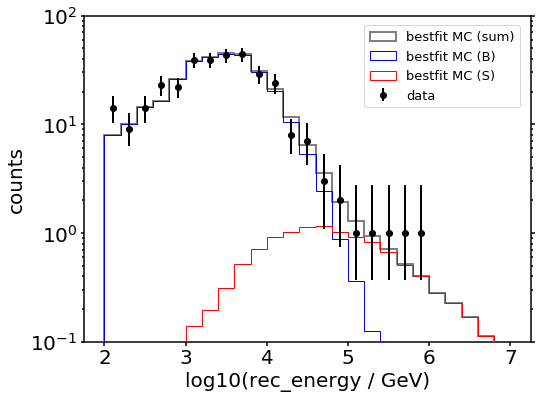

In [33]:
# We repeat the fit but now include the signal parameters
pars_fit, neg_logllh_fit = ana.get_full_fit(bins, pseudo_data, pars_mc)
print pars_fit

# generate the model prediction in each analysis bin from MC for the best-fit parameters
mus = ana.get_expectations(edges, pars_fit)
mus_conv = ana.get_expectations_conv(edges, pars_fit[0])
mus_astro = ana.get_expectations_astro(edges, pars_fit[1:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus, histtype='step', color='gray', linewidth=2, zorder=10, label='bestfit MC (sum)')
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_conv, histtype='step', color='blue', linewidth=1, zorder=10, label='bestfit MC (B)')
contents, bins, _ = plt.hist(centers, bins=edges, weights=mus_astro, histtype='step', color='red', linewidth=1, zorder=10, label='bestfit MC (S)')
ax.errorbar(centers, pseudo_data,yerr=[pseudo_data_err_low, pseudo_data_err_up], label='data', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

ax.set_yscale('log')
ax.set_ylim([1.e-1, 100])
ax.set_xlabel('log10(rec_energy / GeV)', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# the best-fit prefers a non-zero signal contribution (astro_norm_fit = 0.45)
# the set of best-fit values does not exactly match the true parameters, 
# because of statistical variations in the data

In [5]:
# we calculate the test-statistic (likelihood ratio between hypotheses H0 (B) and H1 (S+B), see lecture for details)
results_obs = ana.get_test_statistic(bins, pseudo_data, pars_mc, [pars_H0[0]], pars_H0[1:])
best_fit_obs = results_obs[0]
bg_only_fit = results_obs[1]
ts_obs = results_obs[2]

# the observed TS value is 23.2

print "the observed best fit (full model) is conv_norm=", best_fit_obs[0], "astro_norm=", best_fit_obs[1], "astro_gamma=", best_fit_obs[2]
print "the observed background only fit is conv_norm=", bg_only_fit[0], "(with astro_norm=0.0 const. and astro_gamma undefined)"
print "the observed TS value is -2 log Lambda=", ts_obs

# in order to interpret the meaning of this value, we need to know the distribution of the TS assuming
# that the background-only hypothesis is true

# this distribution is in general unknown. but can be estimated by Monte Carlo (toy experiments)
# we generate  samples from the TS distribution assuming the best-background-fit values are true
# (beware of possible dependencies on nuisance parameters in complicated problems!)

# this is done by repeatedly generating new datasets from best background-only hypothesis
# and then fitting these artificial datasets with both hypothesis (B and S+B).
# i.e. for each dataset we calculate and store the corresponding TS value (one sample)
results_pseudo_data = ana.get_distributions_from_pseudo_data(bins, pars_mc, [pars_H0[0]], pars_H0[1:], pars_H0, 10000)

# unfortunately this is a time-consuming process

the observed best fit (full model) is conv_norm= 1.24639042074718 astro_norm= 0.4462668927377353 astro_gamma= 1.9276694583096934
the observed background only fit is conv_norm= 1.29231543381 (with astro_norm=0.0 const. and astro_gamma undefined)
the observed TS value is -2 log Lambda= 23.187980630000766
analyzed 0 / 10000 datasets.
analyzed 10 / 10000 datasets.
analyzed 20 / 10000 datasets.
analyzed 30 / 10000 datasets.
analyzed 40 / 10000 datasets.
analyzed 50 / 10000 datasets.
analyzed 60 / 10000 datasets.
analyzed 70 / 10000 datasets.
analyzed 80 / 10000 datasets.
analyzed 90 / 10000 datasets.
analyzed 100 / 10000 datasets.
analyzed 110 / 10000 datasets.
analyzed 120 / 10000 datasets.
analyzed 130 / 10000 datasets.
analyzed 140 / 10000 datasets.
analyzed 150 / 10000 datasets.
analyzed 160 / 10000 datasets.
analyzed 170 / 10000 datasets.
analyzed 180 / 10000 datasets.
analyzed 190 / 10000 datasets.
analyzed 200 / 10000 datasets.
analyzed 210 / 10000 datasets.
analyzed 220 / 10000 data

analyze_data_v2.py:52: RuntimeWarning: overflow encountered in power
analyze_data_v2.py:58: RuntimeWarning: invalid value encountered in multiply
analyze_data_v2.py:76: RuntimeWarning: invalid value encountered in less
/home/hans/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


analyzed 830 / 10000 datasets.
analyzed 840 / 10000 datasets.
analyzed 850 / 10000 datasets.
analyzed 860 / 10000 datasets.
analyzed 870 / 10000 datasets.
analyzed 880 / 10000 datasets.
analyzed 890 / 10000 datasets.
analyzed 900 / 10000 datasets.
analyzed 910 / 10000 datasets.
analyzed 920 / 10000 datasets.
analyzed 930 / 10000 datasets.
analyzed 940 / 10000 datasets.
analyzed 950 / 10000 datasets.
analyzed 960 / 10000 datasets.
analyzed 970 / 10000 datasets.
analyzed 980 / 10000 datasets.
analyzed 990 / 10000 datasets.
analyzed 1000 / 10000 datasets.
analyzed 1010 / 10000 datasets.
analyzed 1020 / 10000 datasets.
analyzed 1030 / 10000 datasets.
analyzed 1040 / 10000 datasets.
analyzed 1050 / 10000 datasets.
analyzed 1060 / 10000 datasets.
analyzed 1070 / 10000 datasets.
analyzed 1080 / 10000 datasets.
analyzed 1090 / 10000 datasets.
analyzed 1100 / 10000 datasets.
analyzed 1110 / 10000 datasets.
analyzed 1120 / 10000 datasets.
analyzed 1130 / 10000 datasets.
analyzed 1140 / 10000 dat

analyzed 3400 / 10000 datasets.
analyzed 3410 / 10000 datasets.
analyzed 3420 / 10000 datasets.
analyzed 3430 / 10000 datasets.
analyzed 3440 / 10000 datasets.
analyzed 3450 / 10000 datasets.
analyzed 3460 / 10000 datasets.
analyzed 3470 / 10000 datasets.
analyzed 3480 / 10000 datasets.
analyzed 3490 / 10000 datasets.
analyzed 3500 / 10000 datasets.
analyzed 3510 / 10000 datasets.
analyzed 3520 / 10000 datasets.
analyzed 3530 / 10000 datasets.
analyzed 3540 / 10000 datasets.
analyzed 3550 / 10000 datasets.
analyzed 3560 / 10000 datasets.
analyzed 3570 / 10000 datasets.
analyzed 3580 / 10000 datasets.
analyzed 3590 / 10000 datasets.
analyzed 3600 / 10000 datasets.
analyzed 3610 / 10000 datasets.
analyzed 3620 / 10000 datasets.
analyzed 3630 / 10000 datasets.
analyzed 3640 / 10000 datasets.
analyzed 3650 / 10000 datasets.
analyzed 3660 / 10000 datasets.
analyzed 3670 / 10000 datasets.
analyzed 3680 / 10000 datasets.
analyzed 3690 / 10000 datasets.
analyzed 3700 / 10000 datasets.
analyzed

analyzed 5970 / 10000 datasets.
analyzed 5980 / 10000 datasets.
analyzed 5990 / 10000 datasets.
analyzed 6000 / 10000 datasets.
analyzed 6010 / 10000 datasets.
analyzed 6020 / 10000 datasets.
analyzed 6030 / 10000 datasets.
analyzed 6040 / 10000 datasets.
analyzed 6050 / 10000 datasets.
analyzed 6060 / 10000 datasets.
analyzed 6070 / 10000 datasets.
analyzed 6080 / 10000 datasets.
analyzed 6090 / 10000 datasets.
analyzed 6100 / 10000 datasets.
analyzed 6110 / 10000 datasets.
analyzed 6120 / 10000 datasets.
analyzed 6130 / 10000 datasets.
analyzed 6140 / 10000 datasets.
analyzed 6150 / 10000 datasets.
analyzed 6160 / 10000 datasets.
analyzed 6170 / 10000 datasets.
analyzed 6180 / 10000 datasets.
analyzed 6190 / 10000 datasets.
analyzed 6200 / 10000 datasets.
analyzed 6210 / 10000 datasets.
analyzed 6220 / 10000 datasets.
analyzed 6230 / 10000 datasets.
analyzed 6240 / 10000 datasets.
analyzed 6250 / 10000 datasets.
analyzed 6260 / 10000 datasets.
analyzed 6270 / 10000 datasets.
analyzed

analyzed 8540 / 10000 datasets.
analyzed 8550 / 10000 datasets.
analyzed 8560 / 10000 datasets.
analyzed 8570 / 10000 datasets.
analyzed 8580 / 10000 datasets.
analyzed 8590 / 10000 datasets.
analyzed 8600 / 10000 datasets.
analyzed 8610 / 10000 datasets.
analyzed 8620 / 10000 datasets.
analyzed 8630 / 10000 datasets.
analyzed 8640 / 10000 datasets.
analyzed 8650 / 10000 datasets.
analyzed 8660 / 10000 datasets.
analyzed 8670 / 10000 datasets.
analyzed 8680 / 10000 datasets.
analyzed 8690 / 10000 datasets.
analyzed 8700 / 10000 datasets.
analyzed 8710 / 10000 datasets.
analyzed 8720 / 10000 datasets.
analyzed 8730 / 10000 datasets.
analyzed 8740 / 10000 datasets.
analyzed 8750 / 10000 datasets.
analyzed 8760 / 10000 datasets.
analyzed 8770 / 10000 datasets.
analyzed 8780 / 10000 datasets.
analyzed 8790 / 10000 datasets.
analyzed 8800 / 10000 datasets.
analyzed 8810 / 10000 datasets.
analyzed 8820 / 10000 datasets.
analyzed 8830 / 10000 datasets.
analyzed 8840 / 10000 datasets.
analyzed

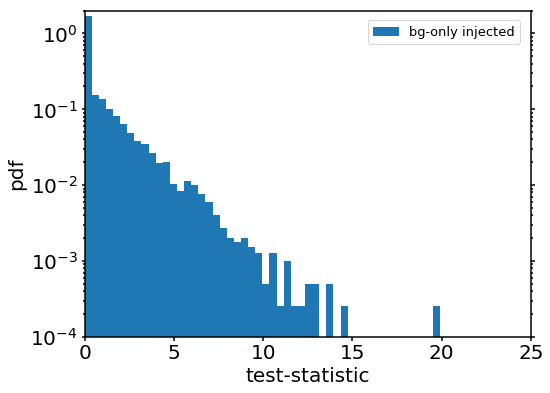

In [11]:
# in order to visualize the TS distribution under the background-only hypothesis
# we fill the TS samples into a histogram

import cPickle as pickle
with open('background_trials.pickle', 'wb') as f:
    pickle.dump(results_pseudo_data, f, protocol=pickle.HIGHEST_PROTOCOL)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(results_pseudo_data[2],bins=50, normed=True, label="bg-only injected")

ax.set_yscale('log')
ax.set_ylim([1.e-4, 2])
ax.set_xlabel('test-statistic', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.set_xlim([0.0, 25.0])
plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# none of our samples exceeds the observed TS value of 23.2.
# thus our estimated p-value would be 0. 
# more trials are needed. typically computed on computer clusters.
# with 10^4 trials one can only bound the p-value to be smaller than ~3 x 10^-4 (~3.5 sigma significance [one-sided])

In [7]:
# what's the distribution of the TS assuming the "true" set of parameters?
# (i.e. is our observed value "typical" given the parameter values that were used to generate the data?)

# Thus we recompute the same TS value as above, but now we generate the pseudo data from the 
# true parameter values
# obviously there are not known before the experiment (and technically not even after ...)
# However sometimes one has a good guess what they should be from theory considerations.
# The "power" of a test is a good metric when designing experiments
results_pseudo_data_H0sig = ana.get_distributions_from_pseudo_data(bins, pars_mc, [pars_H0[0]], pars_H0[1:], pars_nature, 10000)

analyzed 0 / 10000 datasets.
analyzed 10 / 10000 datasets.
analyzed 20 / 10000 datasets.
analyzed 30 / 10000 datasets.
analyzed 40 / 10000 datasets.
analyzed 50 / 10000 datasets.
analyzed 60 / 10000 datasets.
analyzed 70 / 10000 datasets.
analyzed 80 / 10000 datasets.
analyzed 90 / 10000 datasets.
analyzed 100 / 10000 datasets.
analyzed 110 / 10000 datasets.
analyzed 120 / 10000 datasets.
analyzed 130 / 10000 datasets.
analyzed 140 / 10000 datasets.
analyzed 150 / 10000 datasets.
analyzed 160 / 10000 datasets.
analyzed 170 / 10000 datasets.
analyzed 180 / 10000 datasets.
analyzed 190 / 10000 datasets.
analyzed 200 / 10000 datasets.
analyzed 210 / 10000 datasets.
analyzed 220 / 10000 datasets.
analyzed 230 / 10000 datasets.
analyzed 240 / 10000 datasets.
analyzed 250 / 10000 datasets.
analyzed 260 / 10000 datasets.
analyzed 270 / 10000 datasets.
analyzed 280 / 10000 datasets.
analyzed 290 / 10000 datasets.
analyzed 300 / 10000 datasets.
analyzed 310 / 10000 datasets.
analyzed 320 / 1000

analyzed 2600 / 10000 datasets.
analyzed 2610 / 10000 datasets.
analyzed 2620 / 10000 datasets.
analyzed 2630 / 10000 datasets.
analyzed 2640 / 10000 datasets.
analyzed 2650 / 10000 datasets.
analyzed 2660 / 10000 datasets.
analyzed 2670 / 10000 datasets.
analyzed 2680 / 10000 datasets.
analyzed 2690 / 10000 datasets.
analyzed 2700 / 10000 datasets.
analyzed 2710 / 10000 datasets.
analyzed 2720 / 10000 datasets.
analyzed 2730 / 10000 datasets.
analyzed 2740 / 10000 datasets.
analyzed 2750 / 10000 datasets.
analyzed 2760 / 10000 datasets.
analyzed 2770 / 10000 datasets.
analyzed 2780 / 10000 datasets.
analyzed 2790 / 10000 datasets.
analyzed 2800 / 10000 datasets.
analyzed 2810 / 10000 datasets.
analyzed 2820 / 10000 datasets.
analyzed 2830 / 10000 datasets.
analyzed 2840 / 10000 datasets.
analyzed 2850 / 10000 datasets.
analyzed 2860 / 10000 datasets.
analyzed 2870 / 10000 datasets.
analyzed 2880 / 10000 datasets.
analyzed 2890 / 10000 datasets.
analyzed 2900 / 10000 datasets.
analyzed

analyzed 5170 / 10000 datasets.
analyzed 5180 / 10000 datasets.
analyzed 5190 / 10000 datasets.
analyzed 5200 / 10000 datasets.
analyzed 5210 / 10000 datasets.
analyzed 5220 / 10000 datasets.
analyzed 5230 / 10000 datasets.
analyzed 5240 / 10000 datasets.
analyzed 5250 / 10000 datasets.
analyzed 5260 / 10000 datasets.
analyzed 5270 / 10000 datasets.
analyzed 5280 / 10000 datasets.
analyzed 5290 / 10000 datasets.
analyzed 5300 / 10000 datasets.
analyzed 5310 / 10000 datasets.
analyzed 5320 / 10000 datasets.
analyzed 5330 / 10000 datasets.
analyzed 5340 / 10000 datasets.
analyzed 5350 / 10000 datasets.
analyzed 5360 / 10000 datasets.
analyzed 5370 / 10000 datasets.
analyzed 5380 / 10000 datasets.
analyzed 5390 / 10000 datasets.
analyzed 5400 / 10000 datasets.
analyzed 5410 / 10000 datasets.
analyzed 5420 / 10000 datasets.
analyzed 5430 / 10000 datasets.
analyzed 5440 / 10000 datasets.
analyzed 5450 / 10000 datasets.
analyzed 5460 / 10000 datasets.
analyzed 5470 / 10000 datasets.
analyzed

analyzed 7740 / 10000 datasets.
analyzed 7750 / 10000 datasets.
analyzed 7760 / 10000 datasets.
analyzed 7770 / 10000 datasets.
analyzed 7780 / 10000 datasets.
analyzed 7790 / 10000 datasets.
analyzed 7800 / 10000 datasets.
analyzed 7810 / 10000 datasets.
analyzed 7820 / 10000 datasets.
analyzed 7830 / 10000 datasets.
analyzed 7840 / 10000 datasets.
analyzed 7850 / 10000 datasets.
analyzed 7860 / 10000 datasets.
analyzed 7870 / 10000 datasets.
analyzed 7880 / 10000 datasets.
analyzed 7890 / 10000 datasets.
analyzed 7900 / 10000 datasets.
analyzed 7910 / 10000 datasets.
analyzed 7920 / 10000 datasets.
analyzed 7930 / 10000 datasets.
analyzed 7940 / 10000 datasets.
analyzed 7950 / 10000 datasets.
analyzed 7960 / 10000 datasets.
analyzed 7970 / 10000 datasets.
analyzed 7980 / 10000 datasets.
analyzed 7990 / 10000 datasets.
analyzed 8000 / 10000 datasets.
analyzed 8010 / 10000 datasets.
analyzed 8020 / 10000 datasets.
analyzed 8030 / 10000 datasets.
analyzed 8040 / 10000 datasets.
analyzed

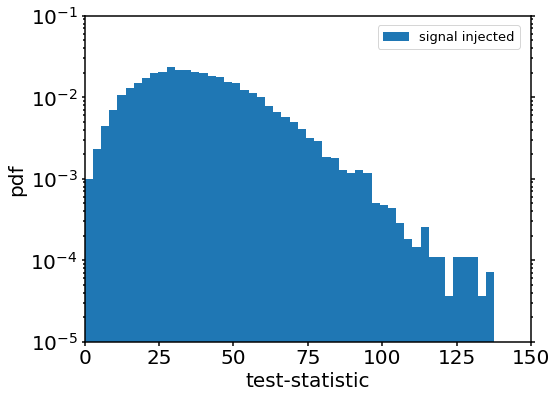

In [15]:
import cPickle as pickle
with open('signal_trials_discoveryTS.pickle', 'wb') as f:
    pickle.dump(results_pseudo_data_H0sig, f, protocol=pickle.HIGHEST_PROTOCOL)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(results_pseudo_data_H0sig[2],bins=50, normed=True, label="signal injected")

ax.set_yscale('log')
ax.set_ylim([1.e-5, 0.1])
ax.set_xlabel('test-statistic', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.set_xlim([0.0, 150.0])
plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

# The observed value 23.2 is pretty much what one would expect given what we injected.

In [9]:
# Finally we compute the distribution of a different TS.
# H0: astro_norm, astro_gamma = (1.0, 2.0), i.e. nominal MC
# H1: astro_norm, astro_gamma != nominal MC

# such test is useful to define confidence regions which we discuss in the coming lectures.

results_pseudo_data_H1 = ana.get_distributions_from_pseudo_data(bins, pars_mc, [pars_mc[0]], pars_mc[1:], pars_mc,10000)

analyzed 0 / 10000 datasets.
analyzed 10 / 10000 datasets.
analyzed 20 / 10000 datasets.
analyzed 30 / 10000 datasets.
analyzed 40 / 10000 datasets.
analyzed 50 / 10000 datasets.
analyzed 60 / 10000 datasets.
analyzed 70 / 10000 datasets.
analyzed 80 / 10000 datasets.
analyzed 90 / 10000 datasets.
analyzed 100 / 10000 datasets.
analyzed 110 / 10000 datasets.
analyzed 120 / 10000 datasets.
analyzed 130 / 10000 datasets.
analyzed 140 / 10000 datasets.
analyzed 150 / 10000 datasets.
analyzed 160 / 10000 datasets.
analyzed 170 / 10000 datasets.
analyzed 180 / 10000 datasets.
analyzed 190 / 10000 datasets.
analyzed 200 / 10000 datasets.
analyzed 210 / 10000 datasets.
analyzed 220 / 10000 datasets.
analyzed 230 / 10000 datasets.
analyzed 240 / 10000 datasets.
analyzed 250 / 10000 datasets.
analyzed 260 / 10000 datasets.
analyzed 270 / 10000 datasets.
analyzed 280 / 10000 datasets.
analyzed 290 / 10000 datasets.
analyzed 300 / 10000 datasets.
analyzed 310 / 10000 datasets.
analyzed 320 / 1000

analyzed 2600 / 10000 datasets.
analyzed 2610 / 10000 datasets.
analyzed 2620 / 10000 datasets.
analyzed 2630 / 10000 datasets.
analyzed 2640 / 10000 datasets.
analyzed 2650 / 10000 datasets.
analyzed 2660 / 10000 datasets.
analyzed 2670 / 10000 datasets.
analyzed 2680 / 10000 datasets.
analyzed 2690 / 10000 datasets.
analyzed 2700 / 10000 datasets.
analyzed 2710 / 10000 datasets.
analyzed 2720 / 10000 datasets.
analyzed 2730 / 10000 datasets.
analyzed 2740 / 10000 datasets.
analyzed 2750 / 10000 datasets.
analyzed 2760 / 10000 datasets.
analyzed 2770 / 10000 datasets.
analyzed 2780 / 10000 datasets.
analyzed 2790 / 10000 datasets.
analyzed 2800 / 10000 datasets.
analyzed 2810 / 10000 datasets.
analyzed 2820 / 10000 datasets.
analyzed 2830 / 10000 datasets.
analyzed 2840 / 10000 datasets.
analyzed 2850 / 10000 datasets.
analyzed 2860 / 10000 datasets.
analyzed 2870 / 10000 datasets.
analyzed 2880 / 10000 datasets.
analyzed 2890 / 10000 datasets.
analyzed 2900 / 10000 datasets.
analyzed

analyzed 5170 / 10000 datasets.
analyzed 5180 / 10000 datasets.
analyzed 5190 / 10000 datasets.
analyzed 5200 / 10000 datasets.
analyzed 5210 / 10000 datasets.
analyzed 5220 / 10000 datasets.
analyzed 5230 / 10000 datasets.
analyzed 5240 / 10000 datasets.
analyzed 5250 / 10000 datasets.
analyzed 5260 / 10000 datasets.
analyzed 5270 / 10000 datasets.
analyzed 5280 / 10000 datasets.
analyzed 5290 / 10000 datasets.
analyzed 5300 / 10000 datasets.
analyzed 5310 / 10000 datasets.
analyzed 5320 / 10000 datasets.
analyzed 5330 / 10000 datasets.
analyzed 5340 / 10000 datasets.
analyzed 5350 / 10000 datasets.
analyzed 5360 / 10000 datasets.
analyzed 5370 / 10000 datasets.
analyzed 5380 / 10000 datasets.
analyzed 5390 / 10000 datasets.
analyzed 5400 / 10000 datasets.
analyzed 5410 / 10000 datasets.
analyzed 5420 / 10000 datasets.
analyzed 5430 / 10000 datasets.
analyzed 5440 / 10000 datasets.
analyzed 5450 / 10000 datasets.
analyzed 5460 / 10000 datasets.
analyzed 5470 / 10000 datasets.
analyzed

analyzed 7740 / 10000 datasets.
analyzed 7750 / 10000 datasets.
analyzed 7760 / 10000 datasets.
analyzed 7770 / 10000 datasets.
analyzed 7780 / 10000 datasets.
analyzed 7790 / 10000 datasets.
analyzed 7800 / 10000 datasets.
analyzed 7810 / 10000 datasets.
analyzed 7820 / 10000 datasets.
analyzed 7830 / 10000 datasets.
analyzed 7840 / 10000 datasets.
analyzed 7850 / 10000 datasets.
analyzed 7860 / 10000 datasets.
analyzed 7870 / 10000 datasets.
analyzed 7880 / 10000 datasets.
analyzed 7890 / 10000 datasets.
analyzed 7900 / 10000 datasets.
analyzed 7910 / 10000 datasets.
analyzed 7920 / 10000 datasets.
analyzed 7930 / 10000 datasets.
analyzed 7940 / 10000 datasets.
analyzed 7950 / 10000 datasets.
analyzed 7960 / 10000 datasets.
analyzed 7970 / 10000 datasets.
analyzed 7980 / 10000 datasets.
analyzed 7990 / 10000 datasets.
analyzed 8000 / 10000 datasets.
analyzed 8010 / 10000 datasets.
analyzed 8020 / 10000 datasets.
analyzed 8030 / 10000 datasets.
analyzed 8040 / 10000 datasets.
analyzed

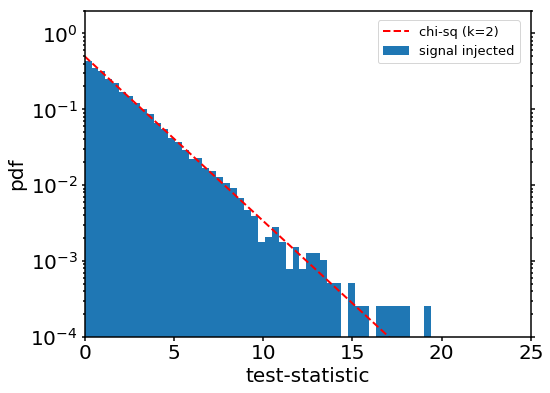

In [63]:
import cPickle as pickle
#with open('signal_trials_clregionTS.pickle', 'wb') as f:
#    pickle.dump(results_pseudo_data_H1, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('signal_trials_clregionTS.pickle', 'rb') as f:
    results_pseudo_data_H1 = pickle.load(f)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(results_pseudo_data_H1[2],bins=50, normed=True, label="signal injected")

ax.set_yscale('log')
ax.set_ylim([1.e-4, 2])
ax.set_xlabel('test-statistic', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.set_xlim([0.0, 25])

from scipy.stats import chi2
xvals = np.linspace(0, 25, 10000)
plt.plot(xvals, chi2.pdf(xvals, 2), "r--", label="chi-sq (k=2)", linewidth=2)

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)
plt.show()

In [29]:
bins_gamma = np.linspace(1.0, 3.0, 41)
bins_norm = np.linspace(0.0, 2.0, 41)

binc_g = 0.5*(bins_gamma[1:]+bins_gamma[:-1])
binc_n = 0.5*(bins_norm[1:]+bins_norm[:-1])

conv_norm_seed = 1.0

TS = np.ones((len(binc_g), len(binc_n)))
for i in range(len(binc_g)):
    for j in range(len(binc_n)):
        seed_full = pars_fit # take from previous best_fit
        seed_restricted = [conv_norm_seed]
        pars_0hypo = [binc_n[j], binc_g[i]]  
        TS[i, j] = ana.get_test_statistic(bins, pseudo_data, seed_full, seed_restricted, pars_0hypo)[-1]
        

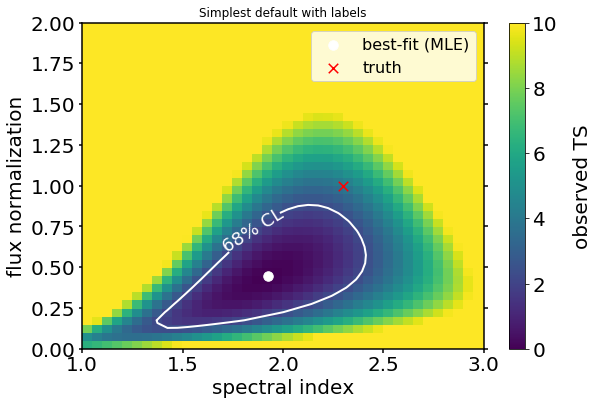

In [49]:
import matplotlib as mpl
vmin,vmax = 0.0, 10.0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
im = ax.pcolormesh(bins_gamma, bins_norm, TS.T, norm=norm)

ax.set_xlabel('spectral index', fontsize=20)
ax.set_ylabel('flux normalization', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

# let's draw a 68% CL? (exercise: verify!) contour

level = chi2.isf(0.32, 2)
Ct = ax.contour(binc_g, binc_n, TS.T, colors='w', levels=level, linewidths=2)
fmt = {}
labels = ['68% CL']
for l,s in zip( Ct.levels, labels):
    fmt[l] = s

ax.clabel(Ct, inline=1, fontsize=18, fmt=fmt)
ax.set_title('Simplest default with labels')


ax.scatter([pars_fit[2]], [pars_fit[1]], label="best-fit (MLE)", color='w', marker='o', s=90)
ax.scatter([pars_nature[2]], [pars_nature[1]], label="truth", color='r', marker='x', s=90)
ax.legend(fontsize=16)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('observed TS', fontsize=20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=20)

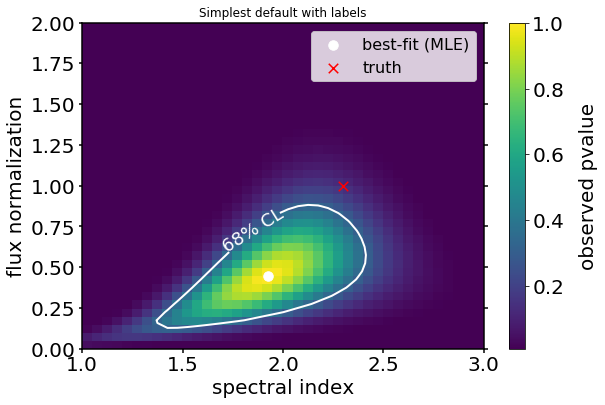

In [62]:
# now do the same assuming we have calculated a grid of p-values

# we use chisquare here, but as demonstrated in the lecture, this needs to be verified using MC

vmin,vmax = 0.01, 1.0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

PVALS = [chi2.sf(x, 2) for x in TS.flatten()]
PVALS = np.array(PVALS).reshape((len(binc_g), len(binc_n)))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
im = ax.pcolormesh(bins_gamma, bins_norm, PVALS.T, norm=norm)

ax.set_xlabel('spectral index', fontsize=20)
ax.set_ylabel('flux normalization', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

# let's draw a 68% CL? (exercise: verify!) contour

level = chi2.isf(0.32, 2)
Ct = ax.contour(binc_g, binc_n, TS.T, colors='w', levels=level, linewidths=2)
fmt = {}
labels = ['68% CL']
for l,s in zip( Ct.levels, labels):
    fmt[l] = s

ax.clabel(Ct, inline=1, fontsize=18, fmt=fmt)
ax.set_title('Simplest default with labels')


ax.scatter([pars_fit[2]], [pars_fit[1]], label="best-fit (MLE)", color='w', marker='o', s=90)
ax.scatter([pars_nature[2]], [pars_nature[1]], label="truth", color='r', marker='x', s=90)
ax.legend(fontsize=16)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('observed pvalue', fontsize=20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=20)

